# Step 1 - Preprocessing, Demographics, Baseline Pointing Error

In [1]:
%matplotlib inline

import os
import json
import gzip
import pickle
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import trimesh

from palettable.colorbrewer.qualitative import Set1_9, Dark2_5
from helpers import confidence_ellipse, annotate_comparison


In [2]:
# Paths and constants
COND_COLORS = Set1_9.mpl_colors[0:3]
FB_COLORS = Dark2_5.mpl_colors[0:4]

FOLDER_DATA = '../data'
FOLDER_FIG = '../figures'
FOLDER_OUT = '../stats'

DROP_PPIDS = ['17'] # P17 has invalid data

## Data Import 

In [3]:
def read_all_participant_data(folder, verbose=False, drop_ppids=[]):
    """ Read a folder full of participant data and return aggregated
    trial, sample and event tables plus session info. 
    """
    data_files = glob(os.path.join(folder, 'VRpoint_*.json.gz'))
    
    sessions = []
    trials = None
    samples = None
    events = None

    print('Importing data files...')
    for df in data_files:
        basename = os.path.splitext(df)[0]

        # Get session-specific data from JSON
        with gzip.open(df, mode='rt') as jf:
            exp = json.load(jf)

        ppid = exp['participant']['id']
        if ppid in drop_ppids:
            print('Skipping PPID {:s}.'.format(str(ppid)))
        else:
            # Drop occlusion conditions (not analyzed here)
            occ = exp['trials'][18]['params']['occluded']
            if occ == 'no':
                sd = {'ppid': ppid,
                      'session': exp['participant']['session'],
                      'feedback': exp['trials'][0]['params']['feedback'],
                      'occluded': occ, 
                      'obj_scale': exp['config']['object_scale'],
                      'age': exp['participant']['age'],
                      'gender': exp['participant']['gender'],
                      'gaze_acc': exp['eye_tracker_validations'][0]['acc'],
                      'gaze_rms': exp['eye_tracker_validations'][0]['rmsi'],
                      'gaze_sd': exp['eye_tracker_validations'][0]['sd'],
                      'ipd': exp['eye_tracker_validations'][0]['ipd'],
                      'wrist_cal_x': exp['config']['wrist_cal']['average_offset'][0],
                      'wrist_cal_y': exp['config']['wrist_cal']['average_offset'][1],
                      'wrist_cal_z': exp['config']['wrist_cal']['average_offset'][2],
                      'data_file': os.path.split(basename)[1][0:-4],
                      'in_file': os.path.split(exp['config']['_trial_input_files'][0])[1]}
                sessions.append(sd)

                tr_file = basename[0:-9] + '.tsv.gz'
                sa_file = basename[0:-9] + '_samples.tsv.gz'
                ev_file = basename[0:-9] + '_events.tsv.gz'

                tr = pd.read_csv(tr_file, sep='\t', index_col=False, compression='gzip')
                ev = pd.read_csv(ev_file, sep='\t', index_col=False, compression='gzip')
                sa = pd.read_csv(sa_file, sep='\t', index_col=False, compression='gzip')

                # Add participant metadata to samples DF
                tr.loc[:, 'ppid'] = ppid
                tr.loc[:, 'session'] = exp['participant']['session']
                ev.loc[:, 'ppid'] = ppid
                ev.loc[:, 'session'] = exp['participant']['session']
                sa.loc[:, 'ppid'] = ppid
                sa.loc[:, 'session'] = exp['participant']['session']

                if trials is None:
                    trials = tr
                else:
                    trials = pd.concat([trials, tr])

                if samples is None:
                    samples = sa
                else:
                    samples = pd.concat([samples, sa])

                if events is None:
                    events = ev
                else:
                    events = pd.concat([events, ev])

                if verbose:
                    print([exp['participant']['id'], exp['participant']['session']])

            else:
                if verbose:
                    print('dropped occlusion condition:', [exp['participant']['id'], exp['participant']['session']])
            
    print('Done.')
    sessions = pd.DataFrame(sessions)
    return sessions, trials, samples, events

In [4]:
# Read all data files
sessions, all_trials, samples, events = read_all_participant_data(FOLDER_DATA, drop_ppids=DROP_PPIDS)
print('Found participants:', sessions.ppid.unique())
print('N=' + str(sessions.ppid.unique().shape[0]))

Importing data files...
Skipping PPID 17.
Skipping PPID 17.
Skipping PPID 17.
Skipping PPID 17.
Skipping PPID 17.
Skipping PPID 17.
Done.
Found participants: ['10' '11' '12' '13' '14' '15' '16' '18' '19' '1' '20' '21' '22' '23' '24'
 '25' '2' '3' '4' '5' '6' '7' '8' '9']
N=24


In [5]:
# Set column data types
sessions.loc[:, 'ppid'] = pd.to_numeric(sessions.loc[:, 'ppid']).astype(int)
sessions.loc[:, 'age'] = pd.to_numeric(sessions.loc[:, 'age']).astype(int)
all_trials.loc[:, 'ppid'] = pd.to_numeric(all_trials.loc[:, 'ppid']).astype(int)
samples.loc[:, 'ppid'] = pd.to_numeric(samples.loc[:, 'ppid']).astype(int)

# Split trials into calibration and object trials
calibs = all_trials.loc[all_trials.type == 'cal', :].copy(deep=True)
trials = all_trials.loc[all_trials.type == 'obj', :].copy(deep=True)

print(all_trials.shape)
print(calibs.shape)
print(trials.shape)

VALID_PPIDS = sessions.ppid.unique()


C:\Users\Immo\AppData\Local\Temp\ipykernel_16760\573848639.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  sessions.loc[:, 'ppid'] = pd.to_numeric(sessions.loc[:, 'ppid']).astype(int)
C:\Users\Immo\AppData\Local\Temp\ipykernel_16760\573848639.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  sessions.loc[:, 'age'] = pd.to_numeric(sessions.loc[:, 'age']).astype(int)
C:\Users\Immo\AppData\Local\Temp\ipykernel_16760\573848639.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace i

(6336, 57)
(1296, 57)
(5040, 57)


C:\Users\Immo\AppData\Local\Temp\ipykernel_16760\573848639.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  samples.loc[:, 'ppid'] = pd.to_numeric(samples.loc[:, 'ppid']).astype(int)


In [6]:
# Compute session durations
sess_dur = trials.loc[:, ['ppid', 'session', 'trial', '_start_tick', '_end_tick']]
dur = []

for ppid in sess_dur.ppid.unique():
    for sess in sess_dur.loc[sess_dur.ppid == ppid, 'session'].unique():
        df = sess_dur.loc[(sess_dur.ppid == ppid) & (sess_dur.session == sess), :]
        dt = df.iloc[-1, :]._end_tick - df.iloc[0, :]._start_tick
        dur.append({'ppid': ppid, 
                    'session': sess,
                    'duration': dt / 60.0})
dur = pd.DataFrame(dur)
display(dur.duration.describe().to_frame().T)

,count,mean,std,min,25%,50%,75%,max
duration,72.0,4.063764,0.52954,3.202973,3.675231,3.96154,4.45732,5.661052


In [7]:
# Functions to help with gaze sample extraction
def find_sample(t, samples):
    """ Find the closest sample to a given time stamp 
    
    Args:
        t (float): Time stamp in seconds
        samples: sample DataFrame
    """
    # Samples time is recorded in ms, trial times are in s
    dt = np.abs(samples.time.values - t)
    return samples.iloc[np.argmin(dt), :]


def find_sample_index(t, samples):
    """ Find index of a sample closest to a time stamp 

    Args:
        t (float): Start time stamp in seconds
        samples: samples DataFrame
    """
    return np.argmin(np.abs(samples.time.values - t))

    
def find_sample_trace(t1, t2, samples):
    """ Select samples between two time stamps
    
    Args:
        t1 (float): Start time stamp in seconds
        t2 (float): End time stamp in seconds
        samples: samples DataFrame
    """
    # Samples time is recorded in ms, trial times are in s
    ix_start = find_sample_index(t1, samples)
    ix_end = find_sample_index(t2, samples)
    return samples.iloc[ix_start:ix_end, :].copy()


In [8]:
## Collect gaze positions for first gaze on object and pointing time
FIELDS = ['gaze_dirX', 'gaze_dirY', 'gaze_dirZ', 'gaze3d_posX', 'gaze3d_posY', 'gaze3d_posZ']
AVG_SAM_MS = 60 # rounded to full samples, ~55.5 ms

trial_sam = []
print(trials.shape)

print('Extracting gaze sample data...')
for sub in VALID_PPIDS:
    for sess in trials.session.unique():

        t = trials.loc[(trials.ppid == sub) & (trials.session == sess), :]
        s = samples.loc[(samples.ppid == sub) & (samples.session == sess), :]
        #print(sub, sess, t.shape, s.shape)
    
        # Find the samples row for each trial button press
        for (tidx, trial) in t.iterrows():
            
            oidx = trial._original_idx
            
            # FINAL gaze position at button press 
            sdata = find_sample_trace((trial.t_confirm * 1000) - AVG_SAM_MS, trial.t_confirm * 1000, s)
            for f in FIELDS:
                trials.loc[(trials.ppid == sub) & (trials.session == sess) & (trials._original_idx == oidx), 'final_{:s}'.format(f)] = sdata.loc[:, f].median()
            
            # Calculate gaze forward vector from Euler components
            R = trimesh.transformations.euler_matrix(np.deg2rad(sdata.loc[:, 'gaze_dirZ'].median()), 
                                                     np.deg2rad(sdata.loc[:, 'gaze_dirY'].median()), 
                                                     np.deg2rad(sdata.loc[:, 'gaze_dirX'].median()), 'ryxz')
            khat = R[0:3, 2]
            trials.loc[(trials.ppid == sub) & (trials.session == sess) & (trials._original_idx == oidx), 'final_gaze_vecX'] = khat[0]
            trials.loc[(trials.ppid == sub) & (trials.session == sess) & (trials._original_idx == oidx), 'final_gaze_vecY'] = khat[1]
            trials.loc[(trials.ppid == sub) & (trials.session == sess) & (trials._original_idx == oidx), 'final_gaze_vecZ'] = khat[2]
            
            # Extract trial trace data between fixation onset and button press + 0.5 s
            trdata = find_sample_trace(trial.t_fix_on * 1000, (trial.t_confirm + 0.5) * 1000, s)
            trdata.loc[:, 'event'] = ''
            trdata.loc[find_sample_index(trial.t_confirm * 1000, s), 'event'] = 'button'
            trdata.loc[find_sample_index(trial.t_fix_on * 1000, s), 'event'] = 'fix_on'
            trdata.loc[find_sample_index(trial.t_fixated * 1000, s), 'event'] = 'fixated'
            trdata.loc[find_sample_index((trial.t_fixated + 0.5) * 1000, s), 'event'] = 'obj_on'
            trial_sam.append(trdata)
            
            # Find points when the fixated object changed
            obj_id = trdata.gaze3d_object.str.split('(', expand=True)[1].str.split(')', expand=True).iloc[:, 0].astype(float)
            trdata.loc[:, 'obj_change'] = (obj_id.diff().values != 0)
            
            # FIRST gaze position = first object change after object onset
            #print(trdata.loc[trdata.obj_change == True, :]) # Number of refixations
            #refix = trdata.loc[(trdata.obj_change == True) & (trdata.object_visible == True), :].iloc[0]
            refix = trdata.loc[(trdata.obj_change == True), :].iloc[0]
            trials.loc[(trials.ppid == sub) & (trials.session == sess) & (trials._original_idx == oidx), 'fix_object'] = int(refix.gaze3d_object.split('(')[1].split(')')[0])
            fdata = find_sample_trace(refix.time, refix.time + AVG_SAM_MS, s)
            for f in FIELDS:
                trials.loc[(trials.ppid == sub) & (trials.session == sess) & (trials._original_idx == oidx), 'first_{:s}'.format(f)] = fdata.loc[:, f].median()
            R = trimesh.transformations.euler_matrix(np.deg2rad(fdata.loc[:, 'gaze_dirZ'].median()), 
                                                     np.deg2rad(fdata.loc[:, 'gaze_dirY'].median()), 
                                                     np.deg2rad(fdata.loc[:, 'gaze_dirX'].median()), 'ryxz')
            khat = R[0:3, 2]
            trials.loc[(trials.ppid == sub) & (trials.session == sess) & (trials._original_idx == oidx), 'first_gaze_vecX'] = khat[0]
            trials.loc[(trials.ppid == sub) & (trials.session == sess) & (trials._original_idx == oidx), 'first_gaze_vecY'] = khat[1]
            trials.loc[(trials.ppid == sub) & (trials.session == sess) & (trials._original_idx == oidx), 'first_gaze_vecZ'] = khat[2]


print('Done.')
print(trials.shape)

(5040, 57)
Extracting gaze sample data...
Done.
(5040, 76)


## Demographics

See Section Methods / Participants.

In [9]:
# Collect demographics from session data and additional information below
demo = [{'ppid': 1, 'vision': 'contacts', 'EHI': 83.3, 'eyedom': 'left'},
        {'ppid': 2, 'vision': 'no', 'EHI': 25, 'eyedom': 'right'},
        {'ppid': 3, 'vision': 'no', 'EHI': 83.3, 'eyedom': 'left'},
        {'ppid': 4, 'vision': 'no', 'EHI': 100, 'eyedom': 'right'},
        {'ppid': 5, 'vision': 'contacts', 'EHI': 100, 'eyedom': 'right'},
        {'ppid': 6, 'vision': 'contacts', 'EHI': 83.3, 'eyedom': 'left'},
        {'ppid': 7, 'vision': 'no', 'EHI': 100, 'eyedom': 'right'},
        {'ppid': 8, 'vision': 'no', 'EHI': 83.3, 'eyedom': 'left'},
        {'ppid': 9, 'vision': 'no', 'EHI': 25, 'eyedom': 'right'},
        {'ppid': 10,'vision': 'contacts', 'EHI': 66.66, 'eyedom': 'right'},
        {'ppid': 11,'vision': 'contacts', 'EHI': 100, 'eyedom': 'right'},
        {'ppid': 12,'vision': 'no', 'EHI': 83.3, 'eyedom': 'left'},
        {'ppid': 13,'vision': 'no', 'EHI': 50, 'eyedom': 'left'},
        {'ppid': 14,'vision': 'no', 'EHI': 100, 'eyedom': 'right'},
        {'ppid': 15,'vision': 'no', 'EHI': 100, 'eyedom': 'right'},
        {'ppid': 16,'vision': 'contacts', 'EHI': 91.6, 'eyedom': 'right'},
        #{'ppid': 17,'vision': 'contacts', 'EHI': 100, 'eyedom': 'right'},
        {'ppid': 18,'vision': 'no', 'EHI': 100, 'eyedom': 'right'},
        {'ppid': 19,'vision': 'no', 'EHI': 66.66, 'eyedom': 'right'},
        {'ppid': 20,'vision': 'no', 'EHI': 100, 'eyedom': 'right'},
        {'ppid': 21,'vision': 'no', 'EHI': 100, 'eyedom': 'right'},
        {'ppid': 22,'vision': 'glasses', 'EHI': 100, 'eyedom': 'right'},
        {'ppid': 23,'vision': 'glasses', 'EHI': 83.3, 'eyedom': 'right'},
        {'ppid': 24,'vision': 'no', 'EHI': 83.3, 'eyedom': 'left'},
        {'ppid': 25,'vision': 'no', 'EHI': 100, 'eyedom': 'right'}]

demo = pd.DataFrame(demo)
demo = demo.merge(sessions.loc[sessions.session == '1', ('ppid', 'age', 'gender', 'ipd', 'gaze_acc', 'gaze_sd')],
                  on='ppid', 
                  how='left')

display(demo.loc[:, ('age', 'EHI', 'ipd', 'gaze_acc')].describe().T.round(2))
display(demo.gender.value_counts().to_frame().T)
display(demo.eyedom.value_counts().to_frame().T)
display(demo.vision.value_counts().to_frame().T)

,count,mean,std,min,25%,50%,75%,max
age,24.0,24.04,4.44,20.00,21.00,23.00,24.00,36.00
EHI,24.0,83.67,22.45,25.00,83.30,87.45,100.00,100.00
ipd,24.0,61.06,3.62,53.93,58.26,61.40,64.52,66.28
gaze_acc,24.0,0.77,0.26,0.43,0.53,0.74,0.95,1.32


,female,male
gender,16,8


,right,left
eyedom,17,7


,no,contacts,glasses
vision,16,6,2


## 3D Coordinate Alignment

In [10]:
# Calculate rotated gaze and raycast endpoints in 3d space,
# this aligns EFRC data with the correct object viewing angle
EFRC_COLS = ['efrc_posX_rot',  'efrc_posY_rot',  'efrc_posZ_rot',  # origin - binocular
             'efrc_vecX_rot',  'efrc_vecY_rot',  'efrc_vecZ_rot',  # direction - binocular
             'efrcL_posX_rot', 'efrcL_posY_rot', 'efrcL_posZ_rot', # origin - left eye
             'efrcL_vecX_rot', 'efrcL_vecY_rot', 'efrcL_vecZ_rot', # direction - right eye
             'efrcR_posX_rot', 'efrcR_posY_rot', 'efrcR_posZ_rot', # origin - right eye
             'efrcR_vecX_rot', 'efrcR_vecY_rot', 'efrcR_vecZ_rot', # direction - right eye
             'efrcD_posX_rot', 'efrcD_posY_rot', 'efrcD_posZ_rot', # origin - DOMINANT eye
             'efrcD_vecX_rot', 'efrcD_vecY_rot', 'efrcD_vecZ_rot', # direction - DOMINANT eye
             
             'first_gaze3d_posX_rot', 'first_gaze3d_posY_rot', 'first_gaze3d_posZ_rot', #  Initial gaze - origin
             'first_gaze3d_vecX_rot', 'first_gaze3d_vecY_rot', 'first_gaze3d_vecZ_rot', #  Initial gaze - direction
             'final_gaze3d_posX_rot', 'final_gaze3d_posY_rot', 'final_gaze3d_posZ_rot', #  Pointing gaze - origin
             'final_gaze3d_vecX_rot', 'final_gaze3d_vecY_rot', 'final_gaze3d_vecZ_rot'  #  Pointing gaze - direction
             ] 
trials.loc[:, EFRC_COLS] = np.nan

# EFRC 3D endpoint on the object (recorded upon button press)
efrc_coords = trials.loc[:, ('efrc_x', 'efrc_y', 'efrc_z')].values
efrcL_coords = trials.loc[:, ('efrcL_x', 'efrcL_y', 'efrcL_z')].values
efrcR_coords = trials.loc[:, ('efrcR_x', 'efrcR_y', 'efrcR_z')].values

# Normalize 3D endpoints so table height equals zero
efrc_coords[:, 1] = efrc_coords[:, 1] - trials.table_height
efrcL_coords[:, 1] = efrcL_coords[:, 1] - trials.table_height
efrcR_coords[:, 1] = efrcR_coords[:, 1] - trials.table_height

# Gaze coordinates on the object
final_gaze_coords = trials.loc[:, ('final_gaze3d_posX', 'final_gaze3d_posY', 'final_gaze3d_posZ')].values
first_gaze_coords = trials.loc[:, ('first_gaze3d_posX', 'first_gaze3d_posY', 'first_gaze3d_posZ')].values

# Gaze normalized
final_gaze_coords[:, 1] = final_gaze_coords[:, 1] - trials.table_height # normalize height
first_gaze_coords[:, 1] = first_gaze_coords[:, 1] - trials.table_height # normalize height

# EFRC direction vector
efrc_dir = trials.loc[:, ('efrc_dir_x', 'efrc_dir_y', 'efrc_dir_z')].values
efrcL_dir = trials.loc[:, ('efrcL_dir_x', 'efrcL_dir_y', 'efrcL_dir_z')].values
efrcR_dir = trials.loc[:, ('efrcR_dir_x', 'efrcR_dir_y', 'efrcR_dir_z')].values

# Gaze direction vectors
final_gaze_dir = trials.loc[:, ('final_gaze_vecX', 'final_gaze_vecY', 'final_gaze_vecZ')].values
first_gaze_dir = trials.loc[:, ('first_gaze_vecX', 'first_gaze_vecY', 'first_gaze_vecZ')].values

# Apply correct rotation to all groups of data points
oris = trials.obj_angle.unique()
for o in oris:
    if np.isnan(o):
        continue

    # For DATA rotation, rotate against original object angle
    R = trimesh.transformations.euler_matrix(np.deg2rad(1 * o), 0, 0, 'ryzx')[:3, :3]

    # Binocular
    efrc_rotated = np.matmul(efrc_coords[trials.obj_angle == o, :], R)
    efrc_dir_rot = np.matmul(efrc_dir[trials.obj_angle == o, :], R)
    trials.loc[trials.obj_angle == o, 'efrc_posX_rot'] = efrc_rotated[:, 0]
    trials.loc[trials.obj_angle == o, 'efrc_posY_rot'] = efrc_rotated[:, 1]
    trials.loc[trials.obj_angle == o, 'efrc_posZ_rot'] = efrc_rotated[:, 2]
    trials.loc[trials.obj_angle == o, 'efrc_vecX_rot'] = efrc_dir_rot[:, 0]
    trials.loc[trials.obj_angle == o, 'efrc_vecY_rot'] = efrc_dir_rot[:, 1]
    trials.loc[trials.obj_angle == o, 'efrc_vecZ_rot'] = efrc_dir_rot[:, 2]
    
    # Left eye
    efrcL_rotated = np.matmul(efrcL_coords[trials.obj_angle == o, :], R)
    efrcL_dir_rot = np.matmul(efrcL_dir[trials.obj_angle == o, :], R)
    trials.loc[trials.obj_angle == o, 'efrcL_posX_rot'] = efrcL_rotated[:, 0]
    trials.loc[trials.obj_angle == o, 'efrcL_posY_rot'] = efrcL_rotated[:, 1]
    trials.loc[trials.obj_angle == o, 'efrcL_posZ_rot'] = efrcL_rotated[:, 2]
    trials.loc[trials.obj_angle == o, 'efrcL_vecX_rot'] = efrcL_dir_rot[:, 0]
    trials.loc[trials.obj_angle == o, 'efrcL_vecY_rot'] = efrcL_dir_rot[:, 1]
    trials.loc[trials.obj_angle == o, 'efrcL_vecZ_rot'] = efrcL_dir_rot[:, 2]

    # Right eye
    efrcR_rotated = np.matmul(efrcR_coords[trials.obj_angle == o, :], R)
    efrcR_dir_rot = np.matmul(efrcR_dir[trials.obj_angle == o, :], R)    
    trials.loc[trials.obj_angle == o, 'efrcR_posX_rot'] = efrcR_rotated[:, 0]
    trials.loc[trials.obj_angle == o, 'efrcR_posY_rot'] = efrcR_rotated[:, 1]
    trials.loc[trials.obj_angle == o, 'efrcR_posZ_rot'] = efrcR_rotated[:, 2]
    trials.loc[trials.obj_angle == o, 'efrcR_vecX_rot'] = efrcR_dir_rot[:, 0]
    trials.loc[trials.obj_angle == o, 'efrcR_vecY_rot'] = efrcR_dir_rot[:, 1]
    trials.loc[trials.obj_angle == o, 'efrcR_vecZ_rot'] = efrcR_dir_rot[:, 2]

    # FINAL gaze
    final_gaze_rotated = np.matmul(final_gaze_coords[trials.obj_angle == o, :], R)
    final_gaze_dir_rot = np.matmul(final_gaze_dir[trials.obj_angle == o, :], R)    
    trials.loc[trials.obj_angle == o, 'final_gaze3d_posX_rot'] = final_gaze_rotated[:, 0]
    trials.loc[trials.obj_angle == o, 'final_gaze3d_posY_rot'] = final_gaze_rotated[:, 1]
    trials.loc[trials.obj_angle == o, 'final_gaze3d_posZ_rot'] = final_gaze_rotated[:, 2]
    trials.loc[trials.obj_angle == o, 'final_gaze3d_vecX_rot'] = final_gaze_dir_rot[:, 0]
    trials.loc[trials.obj_angle == o, 'final_gaze3d_vecY_rot'] = final_gaze_dir_rot[:, 1]
    trials.loc[trials.obj_angle == o, 'final_gaze3d_vecZ_rot'] = final_gaze_dir_rot[:, 2]
    
    # INITIAL gaze
    first_gaze_rotated = np.matmul(first_gaze_coords[trials.obj_angle == o, :], R)
    first_gaze_dir_rot = np.matmul(first_gaze_dir[trials.obj_angle == o, :], R)    
    trials.loc[trials.obj_angle == o, 'first_gaze3d_posX_rot'] = first_gaze_rotated[:, 0]
    trials.loc[trials.obj_angle == o, 'first_gaze3d_posY_rot'] = first_gaze_rotated[:, 1]
    trials.loc[trials.obj_angle == o, 'first_gaze3d_posZ_rot'] = first_gaze_rotated[:, 2]
    trials.loc[trials.obj_angle == o, 'first_gaze3d_vecX_rot'] = first_gaze_dir_rot[:, 0]
    trials.loc[trials.obj_angle == o, 'first_gaze3d_vecY_rot'] = first_gaze_dir_rot[:, 1]
    trials.loc[trials.obj_angle == o, 'first_gaze3d_vecZ_rot'] = first_gaze_dir_rot[:, 2]

    
# Select dominant eye data - copy the correct eye per participant
for pp in trials.ppid.unique():
    dom_eye = demo.loc[demo.ppid == pp, 'eyedom'].str.upper().values[0][0]
    for col in ['efrcD_posX_rot', 'efrcD_posY_rot', 'efrcD_posZ_rot',
                'efrcD_vecX_rot', 'efrcD_vecY_rot', 'efrcD_vecZ_rot']:
        
        eyecol = col[0:4] + dom_eye + col[5:]
        trials.loc[trials.ppid == pp, col] = trials.loc[trials.ppid == pp, eyecol]


In [11]:
# Drop all raycasts that "missed" the object and went to the wall or floor
BOX = 0.5 # +/- around object, in m
MIN_HEIGHT = 0.01 # remove floor fixations

for eye in ['', 'L', 'R', 'D']:
    
    eye_total = 0
    
    filter_x = np.abs(trials.loc[:, 'efrc{:s}_posX_rot'.format(eye)]) >= BOX
    eye_total += trials.loc[filter_x, :].shape[0]
    print('Filtered due to X coordinate ({:s}): {:d} /{:d}'.format(eye, trials.loc[filter_x, :].shape[0], trials.shape[0]))
    trials.loc[filter_x, 'efrc{:s}_posX_rot'.format(eye)] = np.nan
          
    filter_y = np.abs(trials.loc[:, 'efrc{:s}_posY_rot'.format(eye)]) <= MIN_HEIGHT
    eye_total += trials.loc[filter_y, :].shape[0]
    print('Filtered due to Y coordinate (floor fixations; {:s}): {:d} /{:d}'.format(eye, trials.loc[filter_y, :].shape[0], trials.shape[0]))
    trials.loc[filter_y, 'efrc{:s}_posY_rot'.format(eye)] = np.nan
    
    filter_z = np.abs(trials.loc[:, 'efrc{:s}_posZ_rot'.format(eye)]) >= BOX
    eye_total += trials.loc[filter_z, :].shape[0]
    print('Filtered due to Z coordinate ({:s}): {:d} /{:d}'.format(eye, trials.loc[filter_z, :].shape[0], trials.shape[0]) )
    trials.loc[filter_z, 'efrc{:s}_posZ_rot'.format(eye)] = np.nan
    
    print('Total {:s}: {:d} /{:d} ({:.3f}%)'.format(eye, eye_total, trials.shape[0], eye_total / trials.shape[0] * 100))

    

Filtered due to X coordinate (): 204 /5040
Filtered due to Y coordinate (floor fixations; ): 46 /5040
Filtered due to Z coordinate (): 275 /5040
Total : 525 /5040 (10.417%)
Filtered due to X coordinate (L): 178 /5040
Filtered due to Y coordinate (floor fixations; L): 40 /5040
Filtered due to Z coordinate (L): 243 /5040
Total L: 461 /5040 (9.147%)
Filtered due to X coordinate (R): 283 /5040
Filtered due to Y coordinate (floor fixations; R): 67 /5040
Filtered due to Z coordinate (R): 368 /5040
Total R: 718 /5040 (14.246%)
Filtered due to X coordinate (D): 242 /5040
Filtered due to Y coordinate (floor fixations; D): 63 /5040
Filtered due to Z coordinate (D): 326 /5040
Total D: 631 /5040 (12.520%)


In [12]:
# Same filter box for gaze vectors
BOX = 0.5 # +/- around object, in m
MIN_HEIGHT = 0.01 # remove floor fixations

eye_total = 0

filter_x = np.abs(trials.loc[:, 'final_gaze3d_posX_rot']) >= BOX
eye_total += trials.loc[filter_x, :].shape[0]
print('Filtered gaze due to X coordinate ({:s}): {:d} /{:d}'.format(eye, trials.loc[filter_x, :].shape[0], trials.shape[0]))
trials.loc[filter_x, 'final_gaze3d_posX_rot'.format(eye)] = np.nan

filter_y = np.abs(trials.loc[:, 'final_gaze3d_posY_rot']) <= MIN_HEIGHT
eye_total += trials.loc[filter_y, :].shape[0]
print('Filtered gaze due to Y coordinate (floor fixations; {:s}): {:d} /{:d}'.format(eye, trials.loc[filter_y, :].shape[0], trials.shape[0]))
trials.loc[filter_y, 'final_gaze3d_posY_rot'.format(eye)] = np.nan

filter_z = np.abs(trials.loc[:, 'final_gaze3d_posZ_rot']) >= BOX
eye_total += trials.loc[filter_z, :].shape[0]
print('Filtered gaze due to Z coordinate ({:s}): {:d} /{:d}'.format(eye, trials.loc[filter_z, :].shape[0], trials.shape[0]) )
trials.loc[filter_z, 'final_gaze3d_posZ_rot'.format(eye)] = np.nan

print('Total {:s}: {:d} /{:d} ({:.3f}%)'.format(eye, eye_total, trials.shape[0], eye_total / trials.shape[0] * 100))

    

Filtered gaze due to X coordinate (D): 55 /5040
Filtered gaze due to Y coordinate (floor fixations; D): 7 /5040
Filtered gaze due to Z coordinate (D): 61 /5040
Total D: 123 /5040 (2.440%)


## Baseline Pointing & Gaze Accuracy

In [13]:
# Calculate pointing and gaze errors relative to known wall targets

# Combined Raycast
calibs.loc[:, 'point_errX'] = np.abs(calibs.loc[:, 'efrc_x'] - calibs.loc[:, 'tar_x'])
calibs.loc[:, 'point_errY'] = np.abs(calibs.loc[:, 'efrc_y'] - calibs.loc[:, 'tar_y'])
calibs.loc[:, 'point_err'] = np.hypot(calibs.loc[:, 'efrc_x'] - calibs.loc[:, 'tar_x'], 
                                      calibs.loc[:, 'efrc_y'] - calibs.loc[:, 'tar_y'])
# Left and right eye Raycasts
calibs.loc[:, 'point_err_xL'] = np.abs(calibs.loc[:, 'efrcL_x'] - calibs.loc[:, 'tar_x'])
calibs.loc[:, 'point_err_yL'] = np.abs(calibs.loc[:, 'efrcL_y'] - calibs.loc[:, 'tar_y'])
calibs.loc[:, 'point_errL'] = np.hypot(calibs.loc[:, 'efrcL_x'] - calibs.loc[:, 'tar_x'], 
                                        calibs.loc[:, 'efrcL_y'] - calibs.loc[:, 'tar_y'])
calibs.loc[:, 'point_err_xR'] = np.abs(calibs.loc[:, 'efrcR_x'] - calibs.loc[:, 'tar_x'])
calibs.loc[:, 'point_err_yR'] = np.abs(calibs.loc[:, 'efrcR_y'] - calibs.loc[:, 'tar_y'])
calibs.loc[:, 'point_errR'] = np.hypot(calibs.loc[:, 'efrcR_x'] - calibs.loc[:, 'tar_x'], 
                                        calibs.loc[:, 'efrcR_y'] - calibs.loc[:, 'tar_y'])
# Dominant eye raycast
# Select dominant eye data - copy the correct eye per participant
for pp in calibs.ppid.unique():
    dom_eye = demo.loc[demo.ppid == pp, 'eyedom'].str.upper().values[0][0]
    
    calibs.loc[calibs.ppid == pp, 'efrcD_x'] = calibs.loc[calibs.ppid == pp, 'efrc{:s}_x'.format(dom_eye)]
    calibs.loc[calibs.ppid == pp, 'efrcD_y'] = calibs.loc[calibs.ppid == pp, 'efrc{:s}_y'.format(dom_eye)]

    calibs.loc[calibs.ppid == pp, 'point_err_xD'] = np.abs(calibs.loc[calibs.ppid == pp, 'efrc{:s}_x'.format(dom_eye)] - calibs.loc[calibs.ppid == pp, 'tar_x'])
    calibs.loc[calibs.ppid == pp, 'point_err_yD'] = np.abs(calibs.loc[calibs.ppid == pp, 'efrc{:s}_y'.format(dom_eye)] - calibs.loc[calibs.ppid == pp, 'tar_y'])
    calibs.loc[calibs.ppid == pp, 'point_errD'] = np.hypot(calibs.loc[calibs.ppid == pp, 'efrc{:s}_x'.format(dom_eye)] - calibs.loc[calibs.ppid == pp, 'tar_x'], 
                                        calibs.loc[calibs.ppid == pp, 'efrc{:s}_y'.format(dom_eye)] - calibs.loc[calibs.ppid == pp, 'tar_y'])

# Gaze
calibs.loc[:, 'gaze_errX'] = np.abs(calibs.loc[:, 'gaze_x'] - calibs.loc[:, 'tar_x'])
calibs.loc[:, 'gaze_errY'] = np.abs(calibs.loc[:, 'gaze_y'] - calibs.loc[:, 'tar_y'])
calibs.loc[:, 'gaze_err'] = np.hypot(calibs.loc[:, 'gaze_x'] - calibs.loc[:, 'tar_x'], 
                                        calibs.loc[:, 'gaze_y'] - calibs.loc[:, 'tar_y'])


In [14]:
# Drop all baseline trials with missing gaze data
MISS = -99999
calibs_old_n = calibs.shape[0]
cgaze_missing = (calibs.gaze_x <= MISS) | (calibs.gaze_y <= MISS) | (calibs.gaze_z <= MISS)
calibs = calibs.loc[~cgaze_missing]
print('Dropped {:d}/{:d} calibration trials due to missing gaze data at response!'.format(np.sum(cgaze_missing), calibs_old_n))


Dropped 17/1296 calibration trials due to missing gaze data at response!


In [15]:
# Outlier Correction: Drop baseline errors +/- 3SD
CAL_OUTLIER_SD = 3.0
CVARS = ['point_errX', 'point_errY', 'point_err', 
         'point_err_xL', 'point_err_yL', 'point_errL', 
         'point_err_xR', 'point_err_yR', 'point_errR',
         'point_err_xD', 'point_err_yD', 'point_errD',
         'gaze_errX', 'gaze_errY', 'gaze_err']

prev = calibs.shape[0]
for var in CVARS:
    var_m = calibs.loc[:, var].mean()
    var_sd = calibs.loc[:, var].std()
    var_out = (calibs.loc[:, var] <= var_m - (CAL_OUTLIER_SD * var_sd)) | (calibs.loc[:, var] >= var_m + (CAL_OUTLIER_SD * var_sd))
    #print(var, np.round(var_m, 3), np.round(var_sd, 3), np.round(var_out.sum(), 3))
    calibs.loc[var_out, var] = np.nan
    
    if var == 'point_errD':
        # Filter variable based on pointing error outliers
        pe_filter = var_out.copy()

calibs.loc[:, 'cal_outlier'] = pe_filter.astype(int)

print('Dropped {:d}/{:d} baseline trials as outliers!'.format(pe_filter.sum(), prev))

Dropped 16/1279 baseline trials as outliers!


In [16]:
# Convert baseline errors to long format
BL_COLS = ['ppid', 'session', '_original_idx', 'feedback', 'point_err', 'point_errL', 'point_errR', 'point_errD', 'gaze_err']
lmm_baseline = calibs.loc[calibs.cal_outlier == 0, BL_COLS] \
                     .rename(columns={'_original_idx': 'trial'}) \
                     .melt(id_vars=['ppid', 'session', 'trial', 'feedback']) \
                     .rename(columns={'value': 'error_m'})

# Compute baseline errors in degrees (using wall distance)
WALL_DIST = 3.5 # in m
lmm_baseline.loc[:, 'error_deg'] = np.rad2deg(np.arctan2(lmm_baseline.error_m, WALL_DIST))

# Compute comparable to Schwind et al
SCHWIND_WALL_DIST = 2
lmm_baseline.loc[:, 'error_m_schwind'] = SCHWIND_WALL_DIST * np.tan(np.deg2rad(lmm_baseline.error_deg))

In [17]:
# Figure parameters
PAPER_FIGSIZE_FC = 3.75
SMALL_MARKER_ALPHA = 0.1
SMALL_MARKER_SIZE = 3
AVG_MARKER_ALPHA = 1
AVG_MARKER_SIZE = 5
TAR_MARKER_SIZE = 8
ELLIPSE_LW = 1.2
FB_LABELS = {'hand': 'Virtual Hand',
             'cursor': 'Cursor Sphere',
             'none': 'No Feedback'}
FB_MARKERS = {'hand': 'v',
             'cursor': 'o',
             'none': '^'}

In [18]:
def plot_baseline_errors(calibs, figsize=(3.75, 3.75), xlimits=(-1.5, 1.5), ylimits=(0, 3.5), dodge=0.05, metric_dodge=0.3):
    """ Plot pointing and gaze calibration data """
    
    METRICS = ['point_err', 'point_errL', 'point_errR', 'point_errD', 'gaze_err']
    METRIC_MARKERS = {'point_err': 'D', 
                      'point_errL': '<', 
                      'point_errR': '>', 
                      'point_errD': 'o',
                      'gaze_err': '*'}
    METRIC_LABELS = {'point_err': 'Pointing (binocular)', 
                      'point_errL': 'Pointing (left eye)', 
                      'point_errR': 'Pointing (right eye)', 
                      'point_errD': 'Pointing (dominant)',
                      'gaze_err': 'Gaze (binocular)'}
    
    handles = []
    labels = []
    
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=150, 
                           subplot_kw={'facecolor': 'none'})
    # Left Figure: Pointing
    for ix, fb in enumerate(['cursor', 'hand', 'none']):
        
        metric_x = np.linspace(-metric_dodge, +metric_dodge, len(METRICS))
        for mix, metric in enumerate(METRICS):
            
            # By-Participant Data
            for ppid in VALID_PPIDS:
                tr = calibs.loc[(calibs.ppid == ppid) & (calibs.feedback == fb) & (calibs.cal_outlier == 0), :]

                # Average calibration error per ppid, feedback and target
                ax.plot(ix + 1 + metric_x[mix] + (dodge * (np.random.random() - 0.5)), 
                        np.nanmean(tr.loc[:, metric]),
                        marker=METRIC_MARKERS[metric], 
                        markersize=SMALL_MARKER_SIZE, 
                        color=FB_COLORS[ix], alpha=SMALL_MARKER_ALPHA)

            # Across-participant + target average + SEM
            all_err = calibs.loc[(calibs.feedback == fb) & (calibs.cal_outlier == 0), ('ppid', metric)] \
                            .groupby(['ppid'], as_index=False) \
                            .agg('mean') \
                            .loc[:, metric]
            
            N = calibs.loc[(calibs.feedback == fb) & (calibs.cal_outlier == 0), 'ppid'].unique().shape[0]
            m = np.nanmean(all_err)
            sem = np.nanstd(all_err) / np.sqrt(N)
            
            MARKERSIZE = AVG_MARKER_SIZE
            if metric == 'gaze_err':
                MARKERSIZE += 2
            h = ax.errorbar(x=ix+1 + metric_x[mix], 
                            y=m,
                            yerr=sem, 
                            marker=METRIC_MARKERS[metric], 
                            markersize=MARKERSIZE, 
                            alpha=AVG_MARKER_ALPHA, 
                            color=FB_COLORS[ix], 
                            markeredgecolor='k',
                            ecolor='k',
                            linewidth=1.2)
            
            if ix == 0:
                handles.append(Line2D([0], [0], marker=METRIC_MARKERS[metric], color='k', ls='none', markerfacecolor='gray', markersize=MARKERSIZE))
                labels.append(METRIC_LABELS[metric])

    ax.set_xlim([0.5, 3.5])
    ax.set_xticks([1,2,3])
    ax.set_xticklabels(['Sphere', 'Hand', 'None'])
    ax.set_xlabel('Visual Feedback Type', fontsize=11)
    ax.set_ylabel('Pointing or Gaze Error (m)', fontsize=11)
    ax.legend(handles, labels, loc='upper left', frameon=False, fontsize=6, title='Vector Type')
    
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(1.5)
    for axis in ['top','right']:
        ax.spines[axis].set_linewidth(0)

    
    plt.tight_layout()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0.05)


## Plot & Stats: Pointing Errors

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


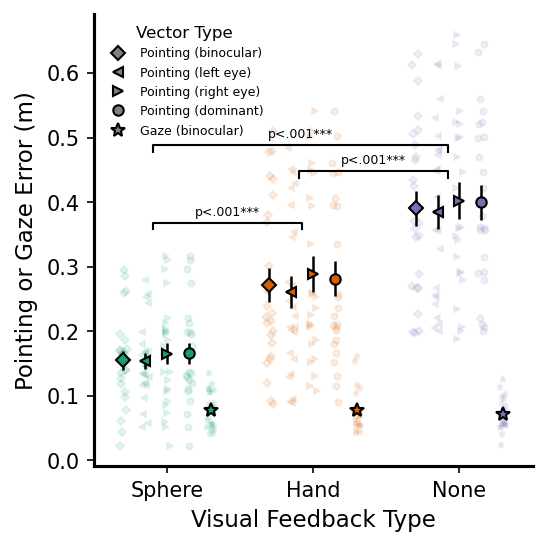

In [26]:
# Figure: Baseline pointing error
plot_baseline_errors(calibs)
plt.setp(plt.gca().get_legend().get_title(), fontsize=8)
annotate_comparison(plt.gca(), 1-0.1, 3-0.075, 0.50, "p<.001***", linewidth=1.0, fontsize=6, height=0.01, color='k')
annotate_comparison(plt.gca(), 2-0.1, 3-0.075, 0.46, "p<.001***", linewidth=1.0, fontsize=6, height=0.01, color='k')
annotate_comparison(plt.gca(), 1-0.1, 2-0.075, 0.38, "p<.001***", linewidth=1.0, fontsize=6, height=0.01, color='k')

plt.tight_layout()
plt.savefig(os.path.join(FOLDER_FIG, 'Fig4_Baseline_Pointing_Error.png'), dpi=300)
plt.savefig(os.path.join(FOLDER_FIG, 'Fig4_Baseline_Pointing_Error.eps'), dpi=300)
plt.savefig(os.path.join(FOLDER_FIG, 'Fig4_Baseline_Pointing_Error.tif'), dpi=300)

In [20]:
# Summary statistics
display(lmm_baseline.groupby(['feedback', 'variable']).error_m.describe())
display(lmm_baseline.groupby('variable').error_m.describe())
display(lmm_baseline.groupby('variable').error_deg.describe())
display(lmm_baseline.groupby('variable').error_m_schwind.describe())

count      mean       std       min       25%       50%  \
feedback variable                                                              
cursor   gaze_err    417.0  0.077773  0.060512  0.000733  0.037778  0.061610   
         point_err   427.0  0.154829  0.095896  0.003268  0.097612  0.145006   
         point_errD  427.0  0.165520  0.103907  0.003268  0.095984  0.152499   
         point_errL  427.0  0.153769  0.089156  0.013539  0.098703  0.136496   
         point_errR  427.0  0.165061  0.107024  0.003268  0.084932  0.156168   
hand     gaze_err    422.0  0.078043  0.061552  0.003819  0.039960  0.059335   
         point_err   429.0  0.272461  0.146494  0.009615  0.165478  0.240174   
         point_errD  429.0  0.281602  0.151192  0.021388  0.166668  0.244265   
         point_errL  429.0  0.261247  0.141628  0.004086  0.155720  0.236120   
         point_errR  429.0  0.289332  0.155397  0.021388  0.171947  0.250460   
none     gaze_err    400.0  0.071836  0.050810  0.003445  0.035563  0.061596   
         point_err   405.0  0.385185  0.208964  0.011992  0.214938  0.353152   
         point_errD  407.0  0.395585  0.210784  0.009272  0.224527  0.362499   
         point_errL  406.0  0.379673  0.207260  0.009272  0.215994  0.348106   
         point_errR  406.0  0.397126  0.214948  0.012496  0.228238  0.360980   

                          75%       max  
feedback variable                        
cursor   gaze_err    0.099736  0.394161  
         point_err   0.186946  0.632682  
         point_errD  0.205565  0.686907  
         point_errL  0.187924  0.628121  
         point_errR  0.211739  0.686907  
hand     gaze_err    0.101709  0.390088  
         point_err   0.387864  0.745670  
         point_errD  0.398700  0.801185  
         point_errL  0.375801  0.738305  
         point_errR  0.407991  0.801185  
none     gaze_err    0.092079  0.348469  
         point_err   0.534938  0.876485  
         point_errD  0.547754  0.912523  
         point_errL  0.528625  0.883355  
         point_errR  0.538656  0.923922

,count,mean,std,min,25%,50%,75%,max
variable,,,,,,,,
gaze_err,1239.0,0.075948,0.057957,0.000733,0.037762,0.060760,0.097440,0.394161
point_err,1261.0,0.268832,0.182099,0.003268,0.136719,0.215959,0.379110,0.876485
point_errD,1263.0,0.279087,0.185563,0.003268,0.144186,0.224805,0.393132,0.912523
point_errL,1262.0,0.262981,0.178084,0.004086,0.128519,0.212140,0.370149,0.883355
point_errR,1262.0,0.281963,0.189264,0.003268,0.144378,0.229403,0.395577,0.923922


,count,mean,std,min,25%,50%,75%,max
variable,,,,,,,,
gaze_err,1239.0,1.242592,0.947005,0.012000,0.618150,0.994554,1.594709,6.425434
point_err,1261.0,4.377925,2.942493,0.053493,2.236991,3.530823,6.182013,14.059117
point_errD,1263.0,4.543844,2.996702,0.053493,2.359017,3.675066,6.408796,14.612901
point_errL,1262.0,4.283407,2.877758,0.066896,2.102948,3.468534,6.036976,14.164898
point_errR,1262.0,4.589943,3.056172,0.053493,2.362154,3.750009,6.448315,14.787491


,count,mean,std,min,25%,50%,75%,max
variable,,,,,,,,
gaze_err,1239.0,0.043399,0.033118,0.000419,0.021578,0.034720,0.055680,0.225235
point_err,1261.0,0.153618,0.104057,0.001867,0.078125,0.123405,0.216634,0.500848
point_errD,1263.0,0.159478,0.106036,0.001867,0.082392,0.128460,0.224647,0.521442
point_errL,1262.0,0.150275,0.101763,0.002335,0.073440,0.121223,0.211514,0.504774
point_errR,1262.0,0.161122,0.108151,0.001867,0.082501,0.131087,0.226044,0.527956


In [21]:
# Pointing accuracy this vs. Schwind studdy (Discussion)
display(lmm_baseline.loc[lmm_baseline.variable == 'point_errL', :].groupby(['feedback']).error_m.describe())
display(lmm_baseline.loc[lmm_baseline.variable == 'point_errL', :].groupby(['feedback']).error_m_schwind.describe())

,count,mean,std,min,25%,50%,75%,max
feedback,,,,,,,,
cursor,427.0,0.153769,0.089156,0.013539,0.098703,0.136496,0.187924,0.628121
hand,429.0,0.261247,0.141628,0.004086,0.155720,0.236120,0.375801,0.738305
none,406.0,0.379673,0.207260,0.009272,0.215994,0.348106,0.528625,0.883355


,count,mean,std,min,25%,50%,75%,max
feedback,,,,,,,,
cursor,427.0,0.087868,0.050946,0.007737,0.056401,0.077998,0.107385,0.358926
hand,429.0,0.149284,0.080930,0.002335,0.088983,0.134926,0.214744,0.421888
none,406.0,0.216956,0.118434,0.005298,0.123425,0.198917,0.302072,0.504774


In [22]:
# Export baseline accuracy for LMM analysis (to be analyzed in Jamovi)
lmm_baseline.loc[lmm_baseline.variable != 'gaze_err', :].to_csv(os.path.join(FOLDER_OUT, 'lmm_baseline_error_pointing.csv'), sep='\t', index=False)
lmm_baseline.loc[lmm_baseline.variable == 'gaze_err', :].to_csv(os.path.join(FOLDER_OUT, 'lmm_baseline_error_gaze.csv'), sep='\t', index=False)

## Eye Tracking Accuracy

In [23]:
# Accuracy and precision measured during the validation task
sessions.loc[:, ('gaze_acc', 'gaze_sd')].describe().T

,count,mean,std,min,25%,50%,75%,max
gaze_acc,72.0,0.755512,0.300475,0.370374,0.515838,0.67403,0.941843,1.673453
gaze_sd,72.0,0.439370,0.301864,0.161068,0.241135,0.34212,0.552701,1.845836


In [24]:
# Gaze error during the baseline task
# In m
display(lmm_baseline.loc[lmm_baseline.variable == 'gaze_err', :].error_m.describe().to_frame().T)
display(lmm_baseline.loc[lmm_baseline.variable == 'gaze_err', :].groupby('feedback').error_m.describe())

# In deg
display(lmm_baseline.loc[lmm_baseline.variable == 'gaze_err', :].error_deg.describe().to_frame().T)
display(lmm_baseline.loc[lmm_baseline.variable == 'gaze_err', :].groupby('feedback').error_deg.describe())


,count,mean,std,min,25%,50%,75%,max
error_m,1239.0,0.075948,0.057957,0.000733,0.037762,0.06076,0.09744,0.394161


,count,mean,std,min,25%,50%,75%,max
feedback,,,,,,,,
cursor,417.0,0.077773,0.060512,0.000733,0.037778,0.061610,0.099736,0.394161
hand,422.0,0.078043,0.061552,0.003819,0.039960,0.059335,0.101709,0.390088
none,400.0,0.071836,0.050810,0.003445,0.035563,0.061596,0.092079,0.348469


,count,mean,std,min,25%,50%,75%,max
error_deg,1239.0,1.242592,0.947005,0.012,0.61815,0.994554,1.594709,6.425434


,count,mean,std,min,25%,50%,75%,max
feedback,,,,,,,,
cursor,417.0,1.272401,0.988763,0.012000,0.618417,1.008458,1.632257,6.425434
hand,422.0,1.276768,1.005496,0.062523,0.654127,0.971228,1.664524,6.359583
none,400.0,1.175462,0.830573,0.056389,0.582158,1.008237,1.507006,5.685769


## Save Preprocessed Data

In [25]:
# Save preprocessed datasets
sessions.to_csv(os.path.join(FOLDER_OUT, 'all_sessions.tsv'), sep='\t', index=False)
trials.to_csv(os.path.join(FOLDER_OUT, 'all_trials.tsv'), sep='\t', index=False)

# Save temporary pickle files
with open(os.path.join(FOLDER_OUT, 'all_sessions.pkl'), 'wb') as pf:
    pickle.dump(sessions, pf)
with open(os.path.join(FOLDER_OUT, 'all_trials.pkl'), 'wb') as pf:
    pickle.dump(trials, pf)
with open(os.path.join(FOLDER_OUT, 'all_calibs.pkl'), 'wb') as pf:
    pickle.dump(calibs, pf)
